In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Generación automática de máscaras de objetos con SAM

Dado que SAM procesa eficientemente las indicaciones, se pueden generar máscaras para toda la imagen muestreando una gran cantidad de indicaciones sobre la misma. Este método se utilizó para generar el conjunto de datos SA-1B.

La clase SamAutomaticMaskGenerator implementa esta capacidad. Funciona muestreando indicaciones de entrada de un solo punto en una cuadrícula sobre la imagen, a partir de cada una de las cuales SAM predice múltiples máscaras. Posteriormente, las máscaras se filtran para mejorar su calidad y se eliminan las duplicadas mediante la supresión de no máximos. Opciones adicionales permiten mejorar aún más la calidad y la cantidad de máscaras, como ejecutar la predicción en múltiples recortes de la imagen o posprocesar las máscaras para eliminar pequeñas regiones desconectadas y huecos.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

Si ejecutas `segment_anything` localmente con Jupyter, primero instala `segment_anything` en tu entorno siguiendo las [instrucciones de instalación](https://github.com/facebookresearch/segment-anything#installation) del repositorio. Si ejecutas desde Google Colab, configura `using_colab=True` (ver más abajo) y ejecuta la celda. En Colab, asegúrate de seleccionar «GPU» en «Editar» → «Configuración del cuaderno» → «Acelerador de hardware».

In [2]:
#using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

NameError: name 'using_colab' is not defined

## Set-up

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [8]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [9]:
image = cv2.imread('mishi.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

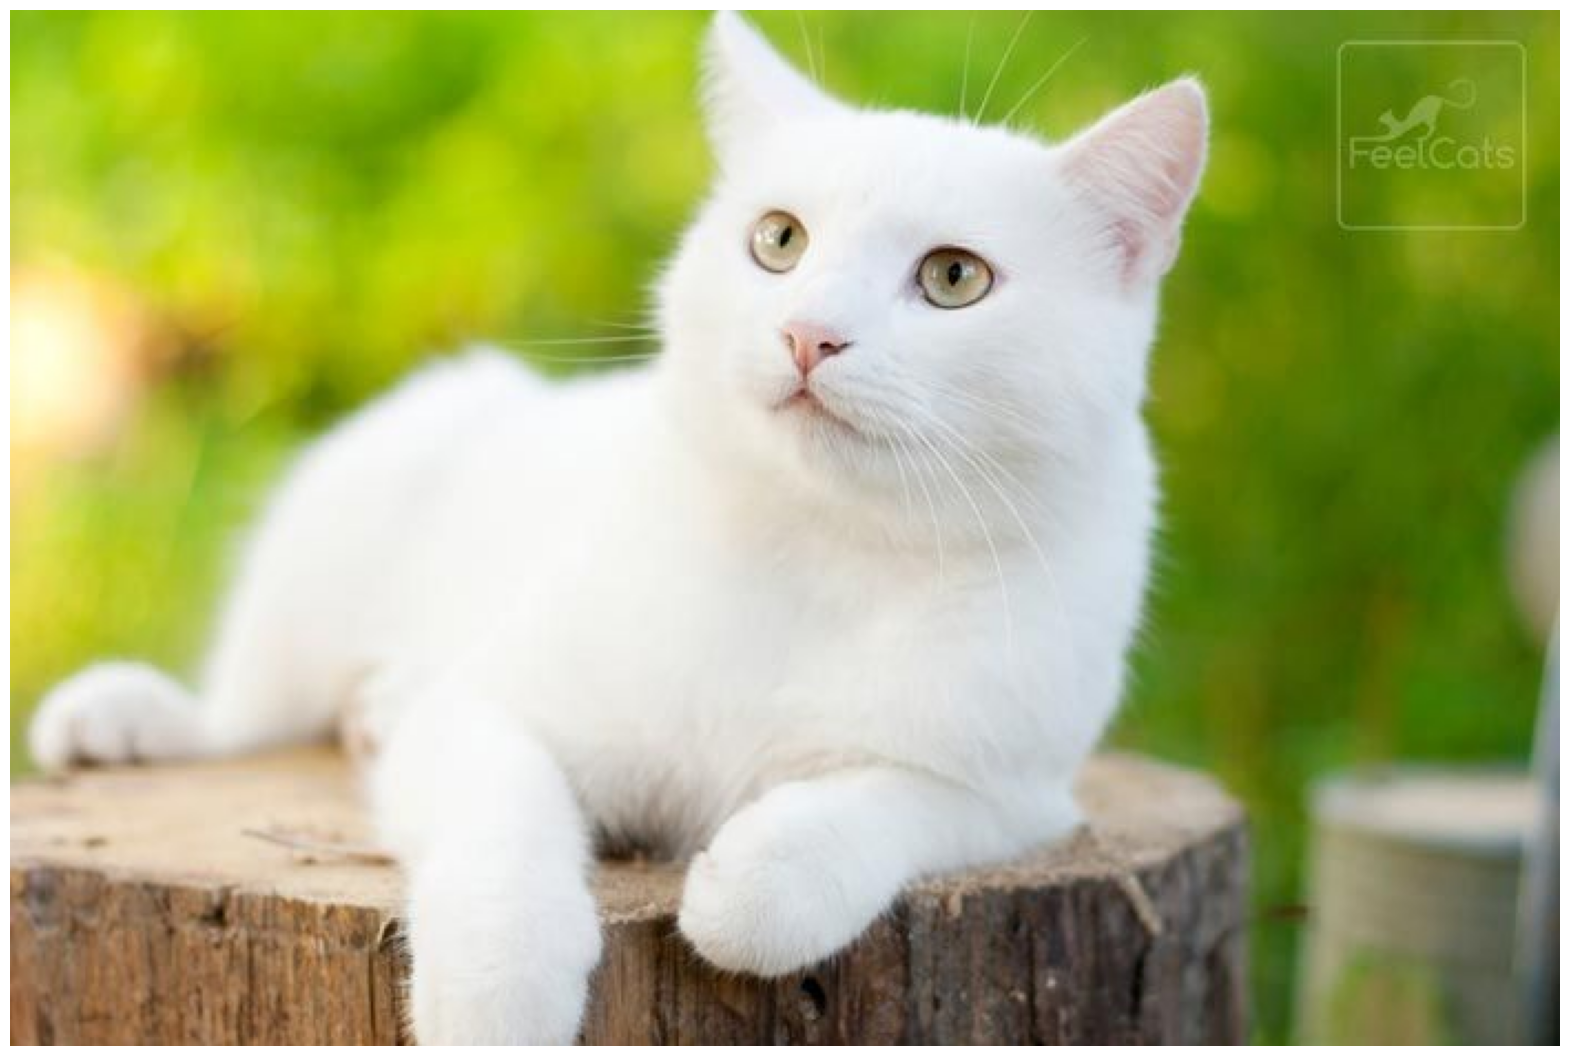

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Generación automática de máscaras

Para ejecutar la generación automática de máscaras, proporcione un modelo SAM a la clase `SamAutomaticMaskGenerator`. Establezca la ruta a la ubicación del punto de control SAM. Se recomienda ejecutar el programa en CUDA con el modelo predeterminado.

In [17]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [18]:
masks = mask_generator.generate(image)

La generación de máscaras devuelve una lista de máscaras, donde cada máscara es un diccionario con diversos datos sobre la misma. Estas claves son: * `segmentation`: la máscara

* `area`: el área de la máscara en píxeles
* `bbox`: el rectángulo delimitador de la máscara en formato XYWH
* `predicted_iou`: la predicción del modelo sobre la calidad de la máscara
* `point_coords`: el punto de entrada muestreado que generó esta máscara
* `stability_score`: una medida adicional de la calidad de la máscara
* `crop_box`: el recorte de la imagen utilizado para generar esta máscara en formato XYWH

In [19]:
print(len(masks))
print(masks[0].keys())

33
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

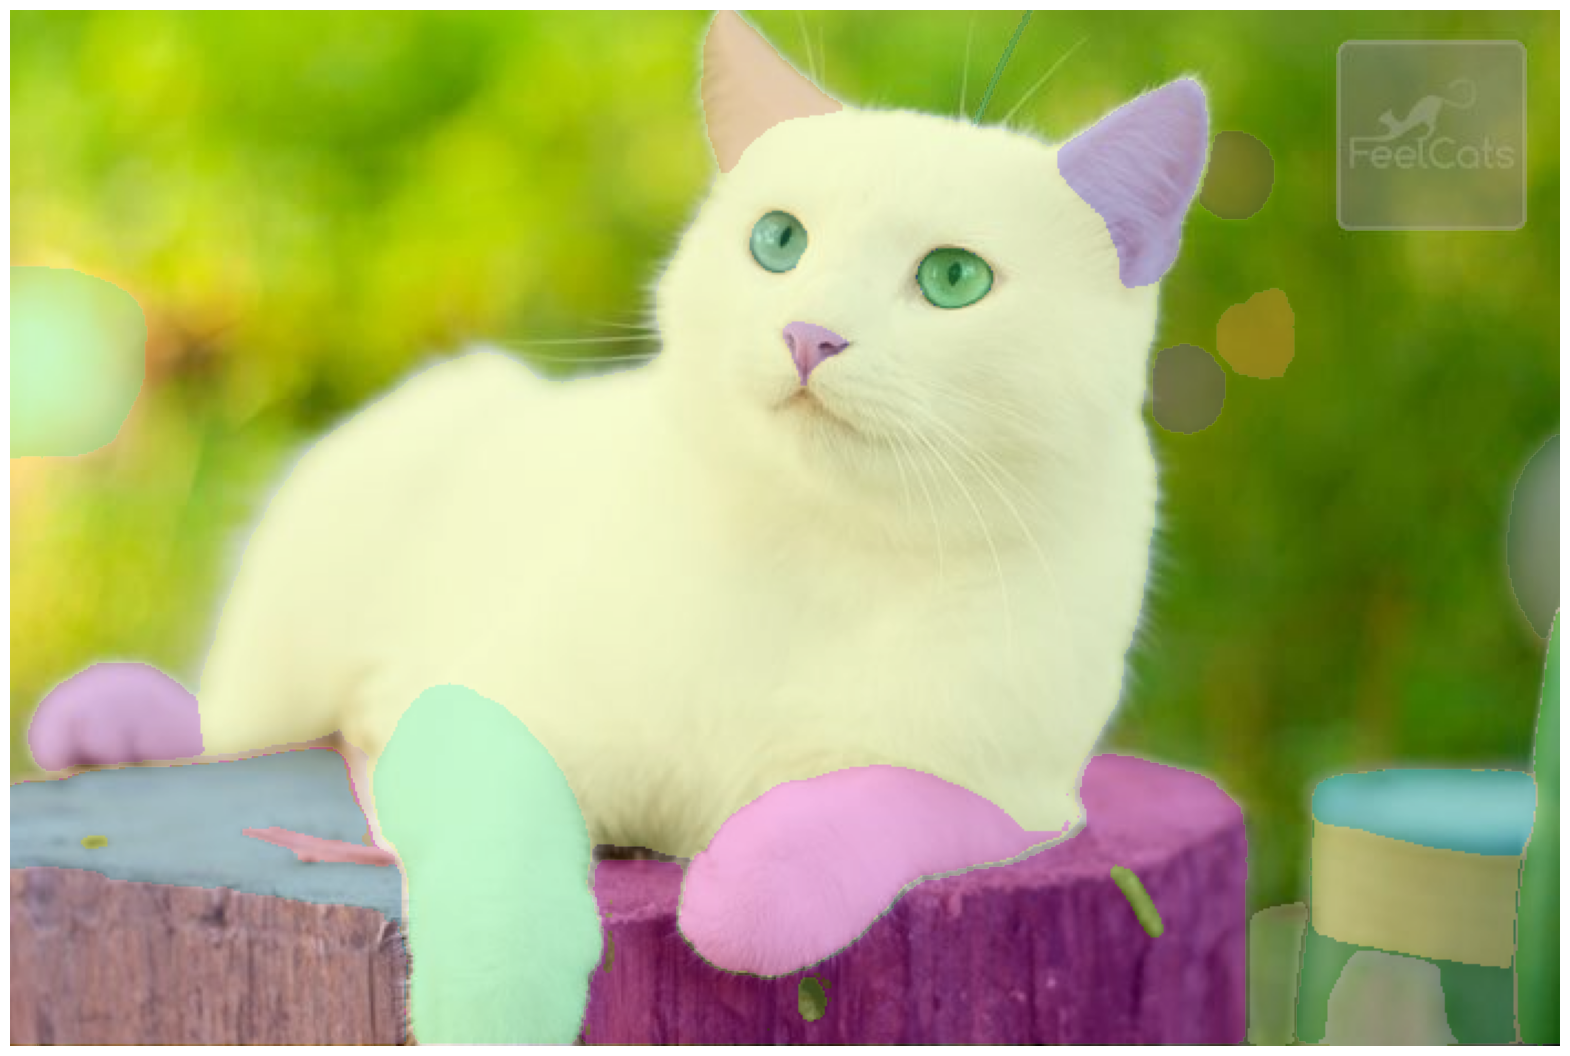

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Opciones de generación automática de máscaras

La generación automática de máscaras cuenta con varios parámetros ajustables que controlan la densidad de muestreo de puntos y los umbrales para eliminar máscaras duplicadas o de baja calidad. Además, la generación puede ejecutarse automáticamente sobre recortes de la imagen para mejorar el rendimiento con objetos pequeños, y el posprocesamiento permite eliminar píxeles sueltos y huecos. A continuación, se muestra una configuración de ejemplo que muestrea más máscaras:

In [21]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [22]:
masks2 = mask_generator_2.generate(image)

In [23]:
len(masks2)

44

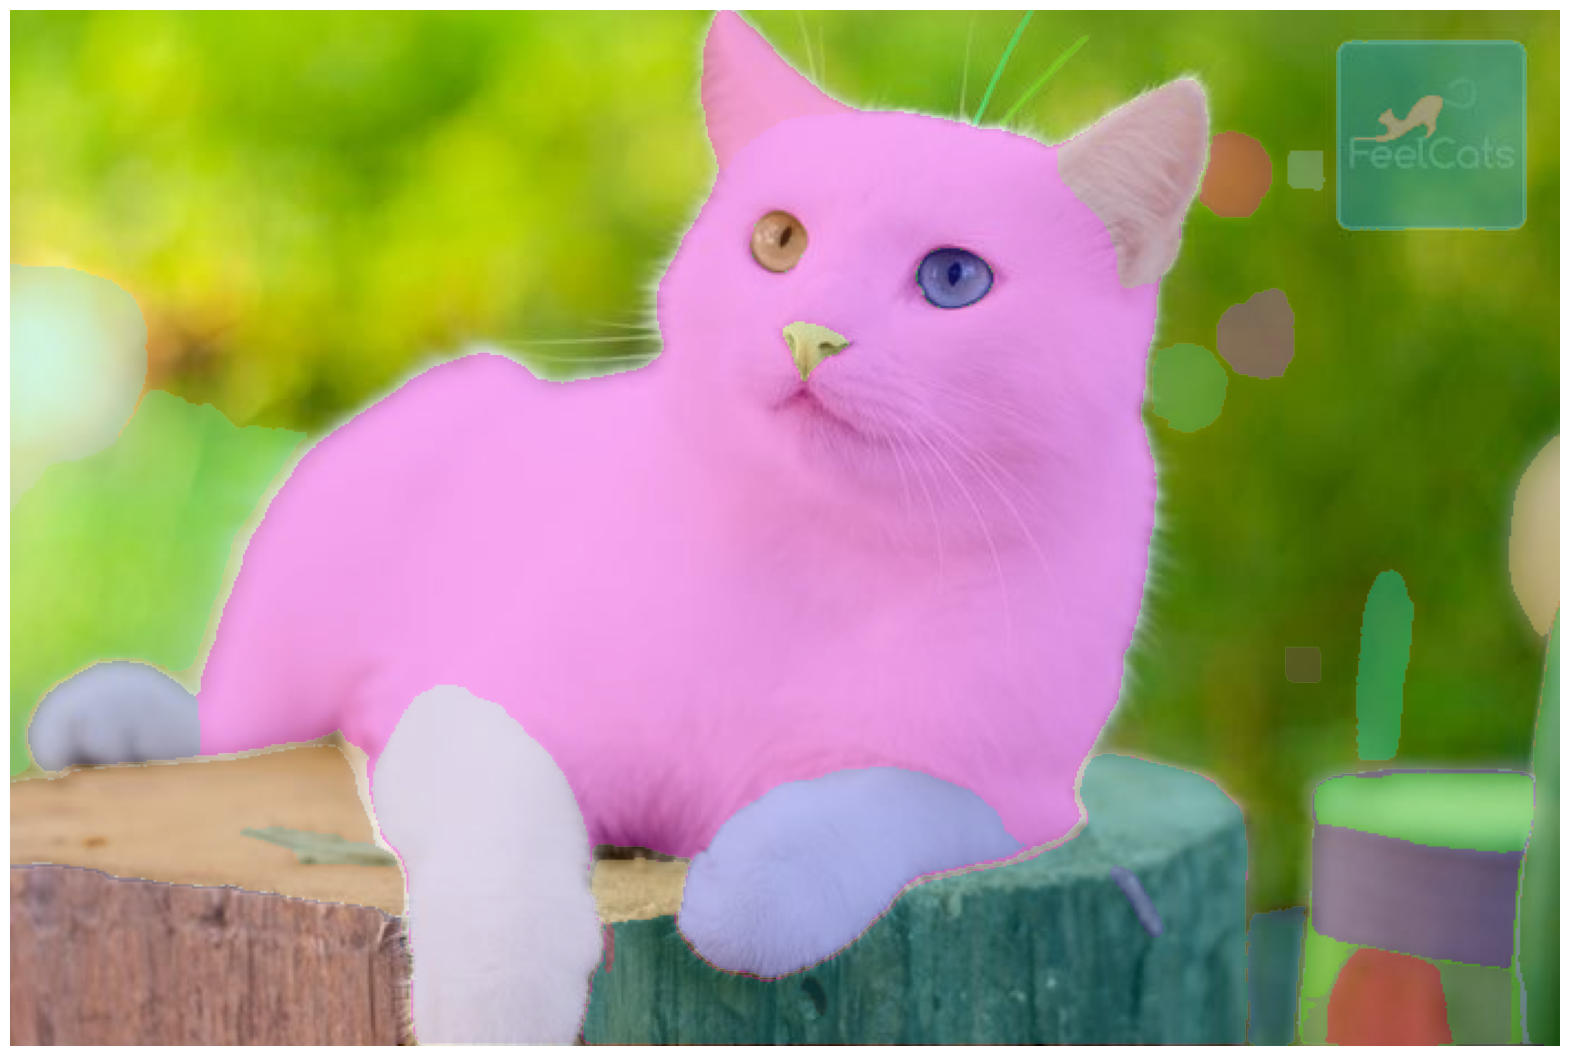

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()